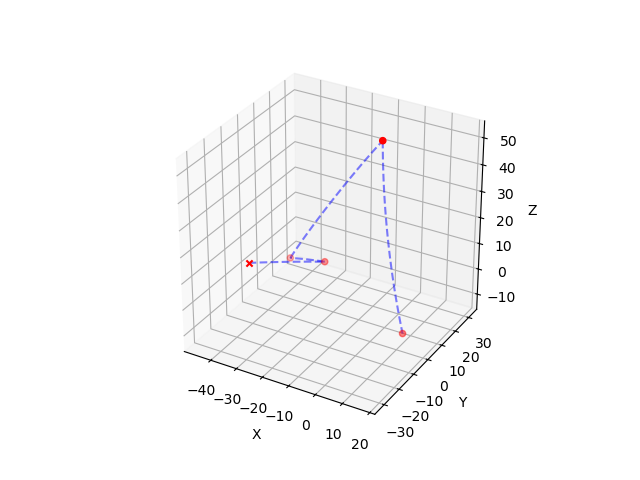

In [1]:
import os
import pickle as pkl
from synthetic_task_gen.create_task import *
%matplotlib widget

sample_params = {"arc_radius_range": [0.5, 5], "waypts_lambda_offset": 1, "min_waypts":2, "max_obj_scale": 150, "coplanar_scale": 2,
                 "keep_ori_prob": 0.6, "screw_prob": 0.4, "screw_step_mult": 2, "min_steps": 15, 
                 "max_steps": 30, "min_objs": 1, "max_objs": 2, 'arc_tilt_deg': [-np.pi, np.pi],
                 'arc_radius_noise': 0.001, 'arc_tilt_noise': 0.001}
waypath_samples, waypt_samples = generate_waypath(sample_params)
display_trajectory(waypath_samples, [waypt_samples])

In [2]:
SAVE_FILE_PATH = f"./saved_data/"
# Fixed Task parameters
NUM_DEMOS = 10
UNIQUE_OBJS = ["obj0", "obj1", "obj2"]
N_OBJS = len(UNIQUE_OBJS)

GENERATION_PARAMS = {"arc_radius_range": [0.5, 150], "waypts_lambda_offset": 1, "min_waypts":2, "max_obj_scale": 150, "coplanar_scale": 2,
                     "keep_ori_prob": 0.6, "screw_prob": 0.4, "screw_step_mult": 2, "min_steps": 15, "max_steps": 30,
                     "min_objs": 1, "max_objs": 2, 'arc_tilt_deg': [-np.pi, np.pi], 'arc_radius_noise': 0.001, 'arc_tilt_noise': 0.001, 
                     "start_point": [-400, -400, 100, 0, 0, 0, 1]}

split_types = ["train", "valid", "test"]
demo_sizes = [10, 25, 50]
dataset_ids = [0, 1, 2]
for dsize in demo_sizes:
    for i in dataset_ids:
        generator = TaskGenerator(GENERATION_PARAMS, UNIQUE_OBJS, n_tasks=dsize)
        generated_dataset = {t:{} for t in generator.task_names}
        for split in split_types:
            generated_data_split = generator.sample_demos(NUM_DEMOS)
            # Create train/valid/test split
            for task_id, dataset in generated_data_split.items():
                generated_dataset[task_id][f"{split}_obj"] = dataset[0]
                generated_dataset[task_id][f"{split}_seq"] = dataset[1]

        # Save task dataset
        save_path = os.path.join(SAVE_FILE_PATH, f"data_{dsize}tasks_{NUM_DEMOS}demos_set{i}.pkl")
        with open(save_path, "wb") as fout:
            pkl.dump(generated_dataset, fout)

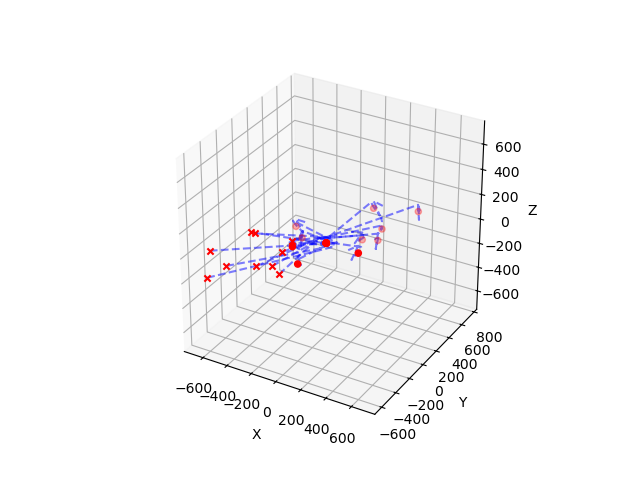

In [3]:
obj_sequence = [] 
traj_sequence = [] 
ith = 1
for i in range(NUM_DEMOS):
    obj_pose = generated_dataset['task0']['train_obj'][i][:,:7]
    traj_pose = generated_dataset['task0']['train_seq'][i][:,:7]
    obj_sequence.append(trajectory_transform(obj_pose, obj_pose[ith,:3], obj_pose[ith,3:7]))
    traj_sequence.append(trajectory_transform(traj_pose, obj_pose[ith,:3], obj_pose[ith,3:7]))
    
display_trajectory(traj_sequence, obj_sequence)

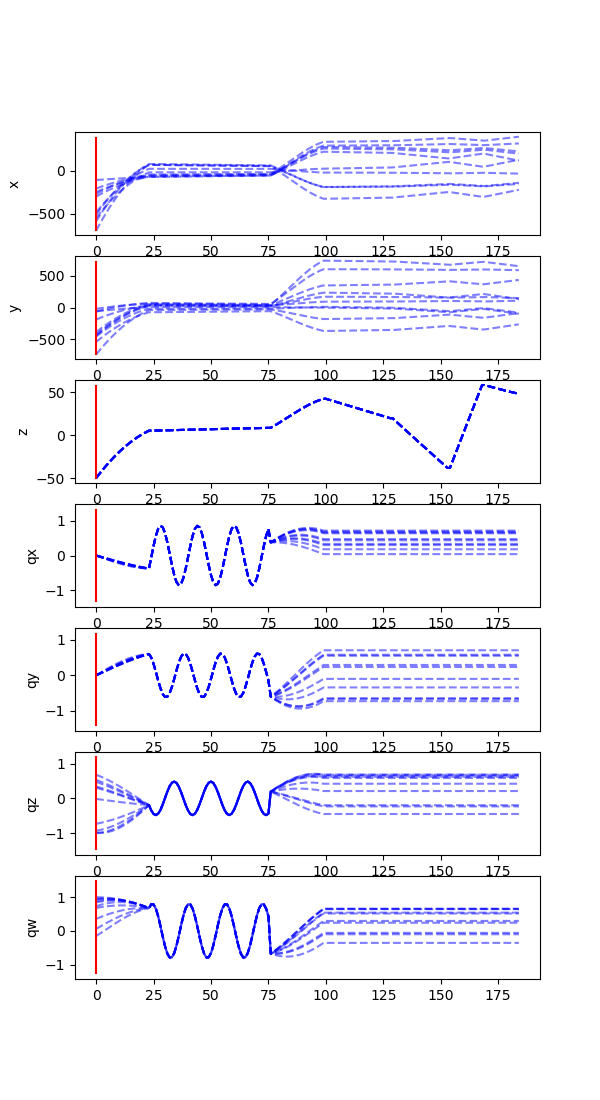

In [4]:
# Plot trajectory overtime
comb_waypath = np.concatenate(traj_sequence, axis=0)
count = 0
check_pts = []
check_pts.append(count)
    
dim_names = ['x','y','z','qx','qy','qz','qw']
dims = len(dim_names)
fig, ax = plt.subplots(dims,1, figsize=(6,11))
for i in range(dims):
    upper, lower = 0, 0
    for traj in traj_sequence:
        upper = max(upper, traj[:,i].max())
        lower = min(lower, traj[:,i].min())
        ax[i].plot(range(traj.shape[0]), traj[:,i], '--', color='blue', alpha=.5)
    ax[i].vlines(check_pts, [lower-0.5 for k in check_pts], [upper+0.5 for k in check_pts], color='red')
    ax[i].set_ylabel(f'{dim_names[i]}')
plt.show()